## Setup: Import libraries for sentiment and thematic analysis

In [285]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji

In [286]:
nlp = spacy.load("en_core_web_sm")
nltk.download('vader_lexicon') # Download the VADER lexicon 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mohammed\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [287]:
sid = SentimentIntensityAnalyzer()

## Load cleaned banks datasets

In [288]:
df_boa = pd.read_csv('../data/boa_cleaned.csv', parse_dates=['date'])
df_cbe = pd.read_csv('../data/cbe_cleaned.csv', parse_dates=['date'])
df_dashen = pd.read_csv('../data/dashen_cleaned.csv', parse_dates=['date'])
df = pd.concat([df_boa, df_cbe, df_dashen])
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   1200 non-null   int64         
 1   review  1200 non-null   object        
 2   rating  1200 non-null   int64         
 3   source  1200 non-null   object        
 4   date    1200 non-null   datetime64[ns]
 5   bank    1200 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 56.4+ KB


## 1- Sentiment Analysis

In [289]:
# Function to clean each review
def clean_text(text):
    if pd.isnull(text):
        return ""
    
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')  # removes all emojis
    
    # Remove non-ASCII characters (Amharic, etc.)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Remove non-alphanumeric characters (except basic punctuation)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?\'"-]', ' ', text)

    # Keep only letters and whitespace
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = text.lower()
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [290]:
df['cleaned_review'] = df['review'].apply(clean_text)

In [291]:
def get_sentiment(text):
    """
    Compute sentiment for a given text.
    Returns:
      sentiment_label: 'positive', 'neutral', or 'negative'
      sentiment_score: compound score as a float
    """
    scores = sid.polarity_scores(text)
    compound = scores['compound']
    # Define thresholds for sentiment labels
    if compound >= 0.05:
        label = 'positive'
    elif compound <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return label, compound


In [292]:
df[['sentiment_label', 'sentiment_score']] = df['review'].apply(lambda x: pd.Series(get_sentiment(x)))

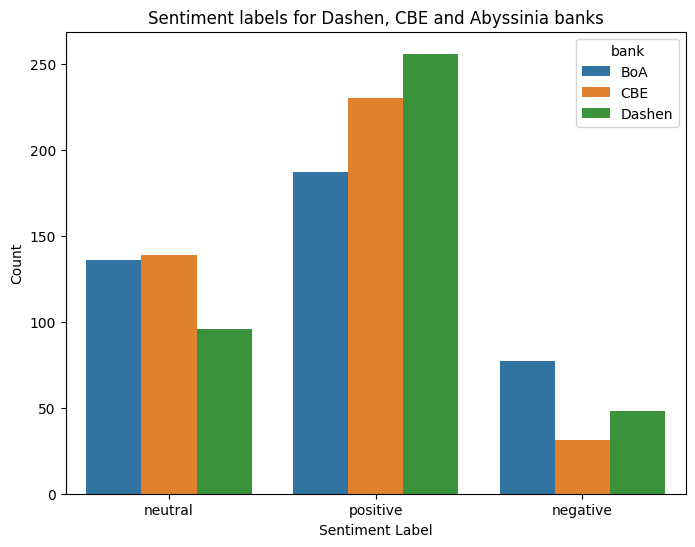

In [293]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='sentiment_label', hue='bank')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment labels for Dashen, CBE and Abyssinia banks')
plt.show()

In [294]:
"""
Preprocessing includes lemmatization and stopword removal, 
which improves keyword extraction quality.
"""
def preprocess_text(text):
    """
    Preprocess the input text:
    - Lowercase
    - Remove stopwords
    - Lemmatize
    - Keep only alphabetic tokens
    """
    # Check if the input is a string
    if not isinstance(text, str):
        return ""
    
    # Use spaCy to process the text
    doc = nlp(text.lower())
    
    # Token filtering: remove stopwords and non-alphabetic tokens, apply lemmatization
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    
    # Join tokens back to a string
    return " ".join(tokens)

In [295]:
# Create a new column with cleaned text
df['cleaned_review'] = df['review'].apply(preprocess_text)

In [296]:
df[['review', 'cleaned_review','sentiment_label']].head(30) ## comparing review and cleaned_review after transformation


,review,cleaned_review,sentiment_label
0,🙏👍,,neutral
1,Very Good,good,positive
2,goof,goof,neutral
3,good!,good,positive
4,good jop,good jop,positive
5,bad exprience...it is so crushed,bad exprience crushed,negative
6,not user friendly at all it requires a huge co...,user friendly require huge connectivity lag time,negative
7,ምንም የማይ ሰራ,ምንም የማይ ሰራ,neutral
8,very good,good,positive
9,most of the time is not working properly,time work properly,neutral


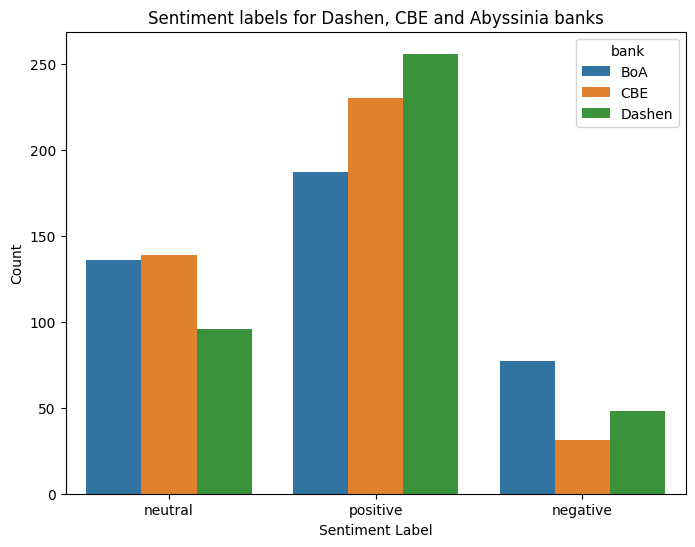

In [297]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='sentiment_label', hue='bank')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment labels for Dashen, CBE and Abyssinia banks')
plt.show()

In [298]:
df.to_csv('../data/cleaned_data.csv')

## 2- Thematic Analysis on the dataset

In [309]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Load your cleaned CSV which contains the critical 'review' column
df = pd.read_csv('../data/cleaned_data.csv')

# Step 1: Use TF-IDF Vectorizer to extract important keywords from each review
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(df['review'])

# Step 2: Cluster the reviews into themes using KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign a theme label to each review from the clustering results
df['identified_theme'] = kmeans.labels_

# View top keywords for each cluster
terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i} top keywords: {top_terms}")

# Step 3: Export the DataFrame with the theme labels to a new CSV file
df.drop(columns=['Unnamed: 0', 'index'], inplace=True)
df.to_csv('../data/cleaned_themed_reviews.csv', index=False)

Cluster 0 top keywords: ['app', 'nice', 'bank', 'wow', 'excellent', 'like', 'great', 'banking', 'use', 'working']
Cluster 1 top keywords: ['good', 'app', 'service', 'application', 'apps', 'really', 'experience', 'fast', 'time', 'work']
Cluster 2 top keywords: ['best', 'app', 'bank', 'ethiopia', 'apps', 'dashen', 'financial', 'easy', 'banking', 'use']


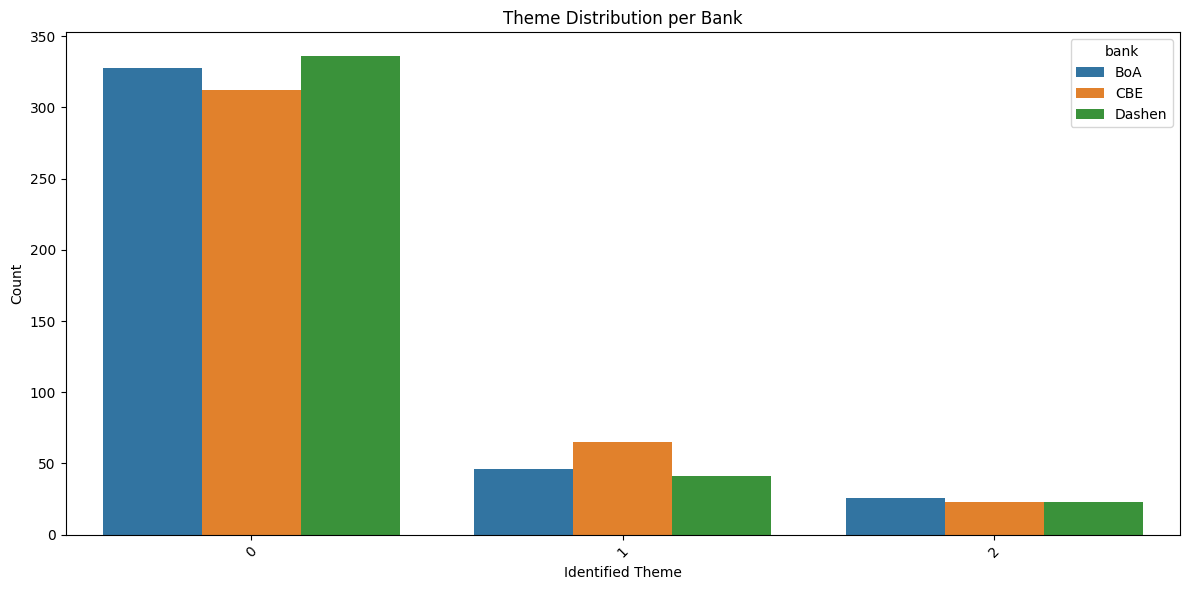

In [310]:
theme_counts = df.groupby(['bank', 'identified_theme']).size().reset_index(name='counts')

# Visualize with a bar plot
plt.figure(figsize=(12,6))
sns.barplot(data=theme_counts, x='identified_theme', y='counts', hue='bank')
plt.title("Theme Distribution per Bank")
plt.xlabel("Identified Theme")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()